<a href="https://colab.research.google.com/github/DhvanilSanghvi/advanced-algo-trading/blob/master/Modelling_stochastic_volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# pymc3_bayes_stochastic_vol.py
import datetime
import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns


In [5]:
def obtain_plot_amazon_prices_dataframe(start_date, end_date):
  """
  Download, calculate and plot the AMZN logarithmic returns.
  """
  print("Downloading and plotting AMZN log returns...")
  amzn = pdr.get_data_yahoo("AMZN", start_date, end_date)
  amzn["returns"] = amzn["Adj Close"]/amzn["Adj Close"].shift(1)
  amzn.dropna(inplace=True)
  amzn["log_returns"] = np.log(amzn["returns"])
  amzn["log_returns"].plot(linewidth=0.5)
  plt.ylabel("AMZN daily percentage returns")
  plt.show()
  return amzn

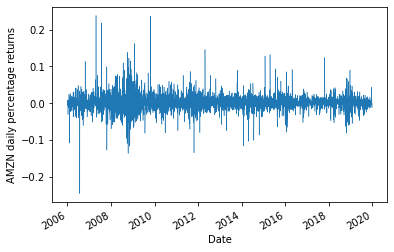

,High,Low,Open,Close,Volume,Adj Close,returns,log_returns
Date,,,,,,,,
2006-01-04,47.730000,46.689999,47.490002,47.250000,7440900,47.250000,0.993064,-0.006960
2006-01-05,48.200001,47.110001,47.160000,47.650002,5417200,47.650002,1.008466,0.008430
2006-01-06,48.580002,47.320000,47.970001,47.869999,6152900,47.869999,1.004617,0.004606
2006-01-09,47.099998,46.400002,46.549999,47.080002,8943100,47.080002,0.983497,-0.016641
2006-01-10,46.750000,45.360001,46.410000,45.650002,9686100,45.650002,0.969626,-0.030845
...,...,...,...,...,...,...,...,...
2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961,0.997886,-0.002116
2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020,1.044467,0.043506
2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049,1.000551,0.000551


In [8]:
obtain_plot_amazon_prices_dataframe('01-01-2006', '01-01-2020')

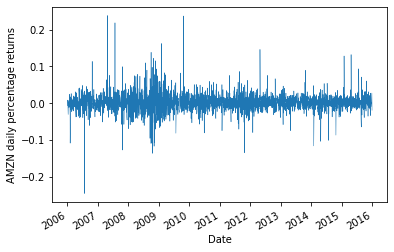

Configuring stochastic volatility with PyMC3...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting the stochastic volatility model...


In [ ]:
def configure_sample_stoch_vol_model(log_returns, samples):
  """
  Configure the stochastic volatility model using PyMC3
  in a ’with’ context. Then sample from the model using
  the No-U-Turn-Sampler (NUTS).
  Plot the logarithmic volatility process and then the
  absolute returns overlaid with the estimated vol.
  """
  print("Configuring stochastic volatility with PyMC3...")
  model = pm.Model()
  with model:
    sigma = pm.Exponential('sigma', 50.0, testval=0.1)
    nu = pm.Exponential('nu', 0.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(log_returns))
    logrets = pm.StudentT(
      'logrets', nu,
      lam=pm.math.exp(-2.0*s),
      observed=log_returns
    )
  print("Fitting the stochastic volatility model...")
  with model:
    trace = pm.sample(samples)
  pm.traceplot(trace, model.vars[:-1])
  plt.show()
  print("Plotting the log volatility...")
  k = 10
  opacity = 0.03
  plt.plot(trace[s][::k].T,'b', alpha=opacity)
  plt.xlabel('Time')
  plt.ylabel('Log Volatility')
  plt.show()
  print("Plotting the absolute returns overlaid with vol...")
  plt.plot(np.abs(np.exp(log_returns))-1.0, linewidth=0.5)
  plt.plot(np.exp(trace[s][::k].T), 'r', alpha=opacity)
  plt.xlabel("Trading Days")
  plt.ylabel("Absolute Returns/Volatility")
  plt.show()

if __name__ == "__main__":
  # State the starting and ending dates of the AMZN returns
  start_date = datetime.datetime(2006, 1, 1)
  end_date = datetime.datetime(2015, 12, 31)
  # Obtain and plot the logarithmic returns of Amazon prices
  amzn_df = obtain_plot_amazon_prices_dataframe(start_date, end_date)
  log_returns = np.array(amzn_df["log_returns"])
  # Configure the stochastic volatility model and carry out
  # MCMC sampling using NUTS, plotting the trace
  samples = 2000
  configure_sample_stoch_vol_model(log_returns, samples)